<a href="https://colab.research.google.com/github/sesmael/Real-Time-ML-/blob/main/homework4_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Problem (1): In this homework, we focus on sequence-to-sequence modeling. Use the English to French Dataset provided.
# Developed a GRU-based encoder-decoder architecture for English to French Translation. Train the model on the entire dataset
# and evaluate it on the entire dataset. Report training loss, validation loss, and validation accuracy. Also, try some qualitative
# validation as well, asking the network to generate French translations for some English sentences.
import torch
import torch.nn as nn
import torch.optim as optim
import random

from data import english_to_french

# -----------------------------
# Hyperparameters and Special Tokens
# -----------------------------
SOS_token = 0
EOS_token = 1
PAD_token = 2

embed_size = 256
hidden_size = 512
learning_rate = 0.01
n_iters = 2000           # Increase iterations for better training
print_every = 100
max_length = 20          # Maximum sentence length for evaluation

# -----------------------------
# Vocabulary Building and Data Preparation
# -----------------------------
def build_vocab(sentences):
    vocab = {"<sos>": SOS_token, "<eos>": EOS_token, "<pad>": PAD_token}
    idx = 3
    for sentence in sentences:
        for word in sentence.split():
            if word not in vocab:
                vocab[word] = idx
                idx += 1
    return vocab

english_sentences = [pair[0] for pair in english_to_french]
french_sentences  = [pair[1] for pair in english_to_french]

input_vocab = build_vocab(english_sentences)
output_vocab = build_vocab(french_sentences)
output_vocab_inv = {idx: word for word, idx in output_vocab.items()}

def sentence_to_tensor(sentence, vocab):
    tokens = sentence.split()  # simple whitespace tokenization
    indices = [vocab[word] for word in tokens]
    indices = [SOS_token] + indices + [EOS_token]
    return torch.tensor(indices, dtype=torch.long)

pairs = []
for eng, fr in english_to_french:
    input_tensor = sentence_to_tensor(eng, input_vocab)
    target_tensor = sentence_to_tensor(fr, output_vocab)
    pairs.append((input_tensor, target_tensor))

# -----------------------------
# Model Definitions: Encoder and Attention-based Decoder
# -----------------------------
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).unsqueeze(1)  # [seq_len, 1, embed_size]
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embed_size, dropout_p=0.1, max_length=20):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embed_size = embed_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, embed_size)
        self.attn_combine = nn.Linear(embed_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        if input.dim() == 0:
            input = input.unsqueeze(0)
        embedded = self.embedding(input).view(1, 1, -1)  # [1, 1, embed_size]
        embedded = self.dropout(embedded)

        # Compute dot-product attention
        hidden_squeezed = hidden.squeeze(0)                    # [1, hidden_size]
        encoder_outputs_squeezed = encoder_outputs.squeeze(1)  # [seq_len, hidden_size]
        hidden_expanded = hidden_squeezed.expand(encoder_outputs_squeezed.size(0), -1)
        attn_scores = torch.sum(hidden_expanded * encoder_outputs_squeezed, dim=1)  # [seq_len]
        attn_weights = torch.softmax(attn_scores, dim=0).unsqueeze(0).unsqueeze(0)   # [1, 1, seq_len]

        encoder_outputs_transposed = encoder_outputs.transpose(0, 1)  # [1, seq_len, hidden_size]
        context = torch.bmm(attn_weights, encoder_outputs_transposed) # [1, 1, hidden_size]

        output = torch.cat((embedded.squeeze(0), context.squeeze(0)), 1)  # [1, embed_size + hidden_size]
        output = self.attn_combine(output).unsqueeze(0)  # [1, 1, hidden_size]
        output = torch.relu(output)

        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights

# Instantiate models
encoder = Encoder(len(input_vocab), embed_size, hidden_size)
decoder = AttnDecoder(hidden_size, len(output_vocab), embed_size, dropout_p=0.1, max_length=max_length)

# -----------------------------
# Training and Evaluation Functions
# -----------------------------
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=0.5):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([SOS_token])
    decoder_hidden = encoder_hidden
    loss = 0

    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            decoder_input = target_tensor[di].unsqueeze(0)
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            predicted_token = topi.item()
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            if predicted_token == EOS_token:
                break
            decoder_input = torch.tensor([predicted_token])

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def evaluate(encoder, decoder, sentence, input_vocab, output_vocab_inv):
    with torch.no_grad():
        input_tensor = sentence_to_tensor(sentence, input_vocab)
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([SOS_token])
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, attn_weights = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            predicted_token = topi.item()
            if predicted_token == EOS_token:
                break
            else:
                decoded_words.append(output_vocab_inv[predicted_token])
            decoder_input = torch.tensor([predicted_token])

        return ' '.join(decoded_words), attn_weights

def compute_token_accuracy(encoder, decoder, pairs, input_vocab, output_vocab_inv):
    total_accuracy = 0.0
    for input_tensor, target_tensor in pairs:
        inv_input_vocab = {idx: word for word, idx in input_vocab.items()}
        english_sentence = " ".join([inv_input_vocab[idx] for idx in input_tensor.tolist() if idx not in [SOS_token, EOS_token, PAD_token]])
        predicted_sentence, _ = evaluate(encoder, decoder, english_sentence, input_vocab, output_vocab_inv)

        target_tokens = [output_vocab_inv[idx] for idx in target_tensor.tolist() if idx not in [SOS_token, EOS_token, PAD_token]]
        predicted_tokens = predicted_sentence.split()
        matches = sum(1 for t, p in zip(target_tokens, predicted_tokens) if t == p)
        sentence_accuracy = matches / len(target_tokens) if target_tokens else 0
        total_accuracy += sentence_accuracy
    return total_accuracy / len(pairs)

def main():
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    total_loss = 0
    for iter in range(1, n_iters + 1):
        training_pair = random.choice(pairs)
        input_tensor, target_tensor = training_pair
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        total_loss += loss
        if iter % print_every == 0:
            avg_loss = total_loss / print_every
            total_loss = 0
            print(f"Iteration {iter}, Average Loss: {avg_loss:.4f}")

    token_acc = compute_token_accuracy(encoder, decoder, pairs, input_vocab, output_vocab_inv)
    print(f"Token-Level Validation Accuracy: {token_acc * 100:.2f}%")

    print("\nQualitative Evaluation:")
    test_sentences = [
        "I am cold",
        "She is happy",
        "They play soccer every weekend",
        "The sun is shining"
    ]

    for sentence in test_sentences:
        translation, _ = evaluate(encoder, decoder, sentence, input_vocab, output_vocab_inv)
        print(f"English: {sentence}")
        print(f"Predicted French: {translation}\n")

if __name__ == "__main__":
    main()


Iteration 100, Average Loss: 3.4090
Iteration 200, Average Loss: 2.8662
Iteration 300, Average Loss: 3.2323
Iteration 400, Average Loss: 3.0414
Iteration 500, Average Loss: 2.8573
Iteration 600, Average Loss: 2.9291
Iteration 700, Average Loss: 2.7941
Iteration 800, Average Loss: 2.6864
Iteration 900, Average Loss: 2.5725
Iteration 1000, Average Loss: 2.3463
Iteration 1100, Average Loss: 2.1409
Iteration 1200, Average Loss: 2.0310
Iteration 1300, Average Loss: 1.9743
Iteration 1400, Average Loss: 1.7399
Iteration 1500, Average Loss: 1.5738
Iteration 1600, Average Loss: 1.4204
Iteration 1700, Average Loss: 1.2928
Iteration 1800, Average Loss: 1.0302
Iteration 1900, Average Loss: 0.9516
Iteration 2000, Average Loss: 0.8175
Token-Level Validation Accuracy: 1.45%

Qualitative Evaluation:
English: I am cold
Predicted French: <sos> J'ai froid

English: She is happy
Predicted French: <sos> Elle nourrit

English: They play soccer every weekend
Predicted French: <sos> Ils jouent au football cha

Iteration 500, Average Loss: 2.3220
Iteration 1000, Average Loss: 0.4226
Iteration 1500, Average Loss: 0.0807
Iteration 2000, Average Loss: 0.0168
Iteration 2500, Average Loss: 0.0036
Iteration 3000, Average Loss: 0.0004
Iteration 3500, Average Loss: 0.0003
Iteration 4000, Average Loss: 0.0002
Iteration 4500, Average Loss: 0.0002
Iteration 5000, Average Loss: 0.0001
Iteration 5500, Average Loss: 0.0001
Iteration 6000, Average Loss: 0.0001
Iteration 6500, Average Loss: 0.0001
Iteration 7000, Average Loss: 0.0000
Iteration 7500, Average Loss: 0.0000
Iteration 8000, Average Loss: 0.0000
Iteration 8500, Average Loss: 0.0000
Iteration 9000, Average Loss: 0.0000
Iteration 9500, Average Loss: 0.0000
Iteration 10000, Average Loss: 0.0000
Token-Level Validation Accuracy: 100.00%

Qualitative Evaluation:
English: I am cold
Predicted French: <sos> J'ai froid



<ipython-input-4-8e291a15aedd>:223: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
<ipython-input-4-8e291a15aedd>:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_sentence.split())


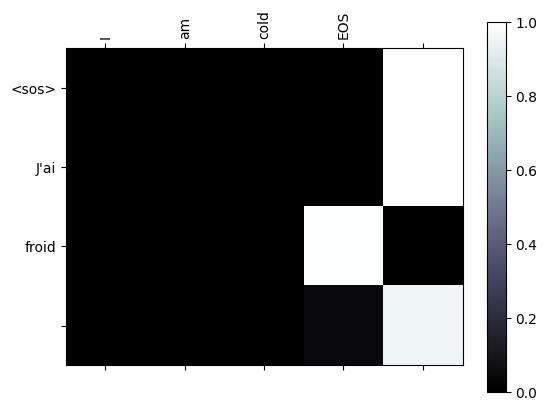

English: She is happy
Predicted French: <sos> Elle est heureuse



<ipython-input-4-8e291a15aedd>:223: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
<ipython-input-4-8e291a15aedd>:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_sentence.split())


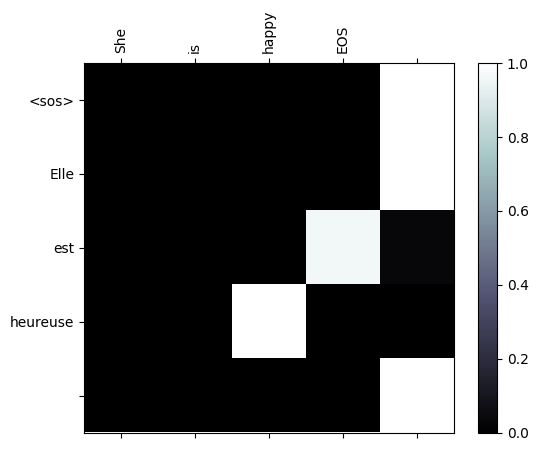

English: They play soccer every weekend
Predicted French: <sos> Ils jouent au football chaque week-end



<ipython-input-4-8e291a15aedd>:223: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
<ipython-input-4-8e291a15aedd>:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_sentence.split())


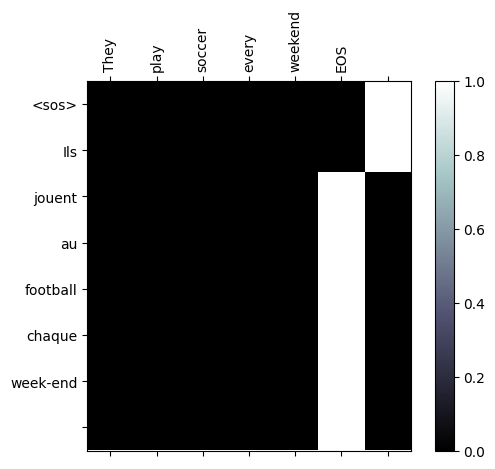

English: The sun is shining
Predicted French: <sos> Le soleil brille



<ipython-input-4-8e291a15aedd>:223: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
<ipython-input-4-8e291a15aedd>:224: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_sentence.split())


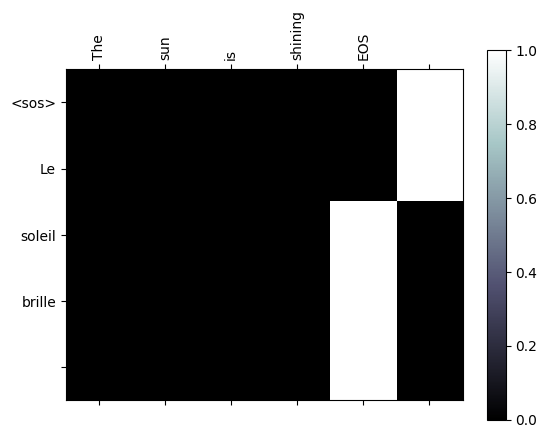

In [4]:
# Problem (2): Repeat problem 1, this time extend the network with attention. Train the model on the entire dataset and
# evaluate it on the entire dataset. Report training loss, validation loss, and validation accuracy. Also, try some qualitative
# validation as well, asking the network to generate French translations for some English sentences. Also, compare the results against problem 1.

import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from data import english_to_french

# -----------------------------
# Hyperparameters and Special Tokens
# -----------------------------
SOS_token = 0
EOS_token = 1
PAD_token = 2

embed_size = 256
hidden_size = 512
learning_rate = 0.001     # Lower learning rate for Adam optimizer
n_iters = 10000           # Increased number of training iterations
print_every = 500
max_length = 20           # Maximum sentence length for evaluation

# -----------------------------
# Vocabulary Building and Data Preparation
# -----------------------------
def build_vocab(sentences):
    vocab = {"<sos>": SOS_token, "<eos>": EOS_token, "<pad>": PAD_token}
    idx = 3
    for sentence in sentences:
        for word in sentence.split():
            if word not in vocab:
                vocab[word] = idx
                idx += 1
    return vocab

english_sentences = [pair[0] for pair in english_to_french]
french_sentences  = [pair[1] for pair in english_to_french]

input_vocab = build_vocab(english_sentences)
output_vocab = build_vocab(french_sentences)
output_vocab_inv = {idx: word for word, idx in output_vocab.items()}

def sentence_to_tensor(sentence, vocab):
    tokens = sentence.split()  # Simple whitespace tokenization
    indices = [vocab[word] for word in tokens]
    indices = [SOS_token] + indices + [EOS_token]
    return torch.tensor(indices, dtype=torch.long)

pairs = []
for eng, fr in english_to_french:
    input_tensor = sentence_to_tensor(eng, input_vocab)
    target_tensor = sentence_to_tensor(fr, output_vocab)
    pairs.append((input_tensor, target_tensor))

# -----------------------------
# Model Definitions: Encoder and Attention-based Decoder
# -----------------------------
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size)

    def forward(self, input, hidden):
        # input: [seq_len]
        embedded = self.embedding(input).unsqueeze(1)  # [seq_len, 1, embed_size]
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embed_size, dropout_p=0.1, max_length=20):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embed_size = embed_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, embed_size)
        self.attn_combine = nn.Linear(embed_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        # Ensure input is 1D (shape [1])
        if input.dim() == 0:
            input = input.unsqueeze(0)
        embedded = self.embedding(input).view(1, 1, -1)  # [1, 1, embed_size]
        embedded = self.dropout(embedded)

        # Dot-product attention:
        hidden_squeezed = hidden.squeeze(0)             # [1, hidden_size]
        encoder_outputs_squeezed = encoder_outputs.squeeze(1)  # [seq_len, hidden_size]
        hidden_expanded = hidden_squeezed.expand(encoder_outputs_squeezed.size(0), -1)
        attn_scores = torch.sum(hidden_expanded * encoder_outputs_squeezed, dim=1)  # [seq_len]
        attn_weights = torch.softmax(attn_scores, dim=0).unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len]

        # Compute context vector as weighted sum of encoder outputs.
        encoder_outputs_transposed = encoder_outputs.transpose(0, 1)  # [1, seq_len, hidden_size]
        context = torch.bmm(attn_weights, encoder_outputs_transposed)   # [1, 1, hidden_size]

        # Combine embedded input and context.
        output = torch.cat((embedded.squeeze(0), context.squeeze(0)), 1)  # [1, embed_size + hidden_size]
        output = self.attn_combine(output).unsqueeze(0)  # [1, 1, hidden_size]
        output = torch.relu(output)

        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights

# Instantiate models.
encoder = Encoder(len(input_vocab), embed_size, hidden_size)
decoder = AttnDecoder(hidden_size, len(output_vocab), embed_size, dropout_p=0.1, max_length=max_length)

# -----------------------------
# Training and Evaluation Functions
# -----------------------------
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=0.75):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_input = torch.tensor([SOS_token])
    decoder_hidden = encoder_hidden
    loss = 0

    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            decoder_input = target_tensor[di].unsqueeze(0)
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            predicted_token = topi.item()
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            if predicted_token == EOS_token:
                break
            decoder_input = torch.tensor([predicted_token])

    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def evaluate(encoder, decoder, sentence, input_vocab, output_vocab_inv):
    with torch.no_grad():
        input_tensor = sentence_to_tensor(sentence, input_vocab)
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([SOS_token])
        decoder_hidden = encoder_hidden
        decoded_words = []
        attentions = torch.zeros(max_length, input_tensor.size(0))

        for di in range(max_length):
            decoder_output, decoder_hidden, attn_weight = decoder(decoder_input, decoder_hidden, encoder_outputs)
            attentions[di] = attn_weight.squeeze()  # [input_length]
            topv, topi = decoder_output.topk(1)
            predicted_token = topi.item()
            if predicted_token == EOS_token:
                break
            decoded_words.append(output_vocab_inv[predicted_token])
            decoder_input = torch.tensor([predicted_token])

        return ' '.join(decoded_words), attentions[:di+1]

def compute_token_accuracy(encoder, decoder, pairs, input_vocab, output_vocab_inv):
    total_accuracy = 0.0
    for input_tensor, target_tensor in pairs:
        # Reconstruct the English sentence from input tensor
        inv_input_vocab = {idx: word for word, idx in input_vocab.items()}
        english_sentence = " ".join([inv_input_vocab[idx] for idx in input_tensor.tolist() if idx not in [SOS_token, EOS_token, PAD_token]])
        predicted_sentence, _ = evaluate(encoder, decoder, english_sentence, input_vocab, output_vocab_inv)

        # Convert both target and predicted sentences into token lists, ignoring special tokens
        target_tokens = [output_vocab_inv[idx] for idx in target_tensor.tolist() if idx not in [SOS_token, EOS_token, PAD_token]]
        predicted_tokens = predicted_sentence.split()
        # Remove the <sos> token from predicted tokens if present
        if predicted_tokens and predicted_tokens[0] == "<sos>":
            predicted_tokens = predicted_tokens[1:]

        matches = sum(1 for t, p in zip(target_tokens, predicted_tokens) if t == p)
        sentence_accuracy = matches / len(target_tokens) if target_tokens else 0
        total_accuracy += sentence_accuracy
    return total_accuracy / len(pairs)

def show_attention(input_sentence, output_sentence, attentions):
    """
    Plots the attention matrix.
    - input_sentence: Original English sentence.
    - output_sentence: Generated French sentence.
    - attentions: Tensor of shape [output_length, input_length].
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
    ax.set_yticklabels([''] + output_sentence.split())

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

# -----------------------------
# Main Training Loop and Evaluation
# -----------------------------
def main():
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    total_loss = 0
    for iter in range(1, n_iters + 1):
        training_pair = random.choice(pairs)
        input_tensor, target_tensor = training_pair
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        total_loss += loss
        if iter % print_every == 0:
            avg_loss = total_loss / print_every
            total_loss = 0
            print(f"Iteration {iter}, Average Loss: {avg_loss:.4f}")

    token_acc = compute_token_accuracy(encoder, decoder, pairs, input_vocab, output_vocab_inv)
    print(f"Token-Level Validation Accuracy: {token_acc * 100:.2f}%")

    print("\nQualitative Evaluation:")
    test_sentences = [
        "I am cold",
        "She is happy",
        "They play soccer every weekend",
        "The sun is shining"
    ]

    for sentence in test_sentences:
        translation, attn = evaluate(encoder, decoder, sentence, input_vocab, output_vocab_inv)
        print(f"English: {sentence}")
        print(f"Predicted French: {translation}\n")
        show_attention(sentence, translation, attn)

if __name__ == "__main__":
    main()


Training Plain Seq2Seq Model for French-to-English Translation
[Plain] Iteration 500, Average Loss: 2.0530
[Plain] Iteration 1000, Average Loss: 0.3804
[Plain] Iteration 1500, Average Loss: 0.0513
[Plain] Iteration 2000, Average Loss: 0.0017
[Plain] Iteration 2500, Average Loss: 0.0008
[Plain] Iteration 3000, Average Loss: 0.0005
[Plain] Iteration 3500, Average Loss: 0.0003
[Plain] Iteration 4000, Average Loss: 0.0003
[Plain] Iteration 4500, Average Loss: 0.0002
[Plain] Iteration 5000, Average Loss: 0.0001
[Plain] Token-Level Validation Accuracy: 0.00%

Plain Model Qualitative Evaluation:
French: J'ai froid
Predicted English: <sos> I am cold

French: Elle est heureuse
Predicted English: <sos> She is happy

French: Ils jouent au football chaque week-end
Predicted English: <sos> They play soccer every weekend

French: Le soleil brille
Predicted English: <sos> The sun is shining



Training Attention-based Model for French-to-English Translation
[Attn] Iteration 1000, Average Loss: 1.2246

<ipython-input-1-0a8c39e377c5>:289: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
<ipython-input-1-0a8c39e377c5>:290: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_sentence.split())


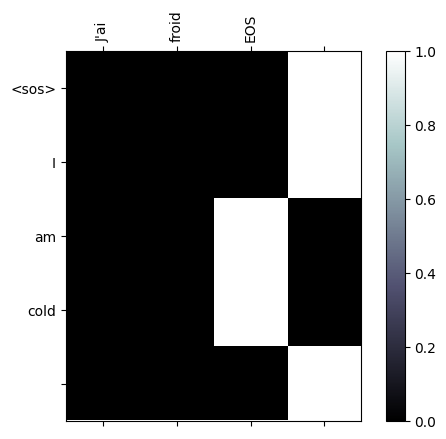

French: Elle est heureuse
Predicted English: <sos> She is happy



<ipython-input-1-0a8c39e377c5>:289: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
<ipython-input-1-0a8c39e377c5>:290: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_sentence.split())


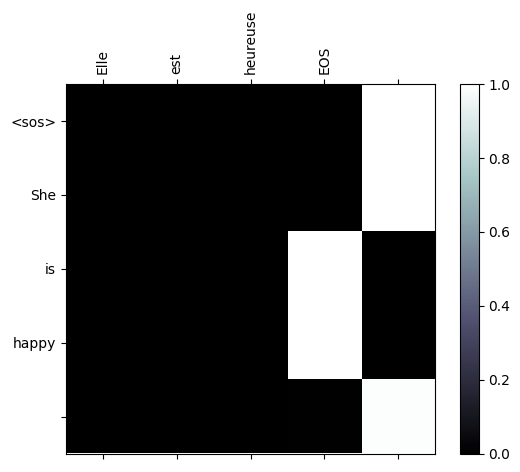

<ipython-input-1-0a8c39e377c5>:289: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)


French: Ils jouent au football chaque week-end
Predicted English: <sos> They play soccer every weekend



<ipython-input-1-0a8c39e377c5>:290: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_sentence.split())


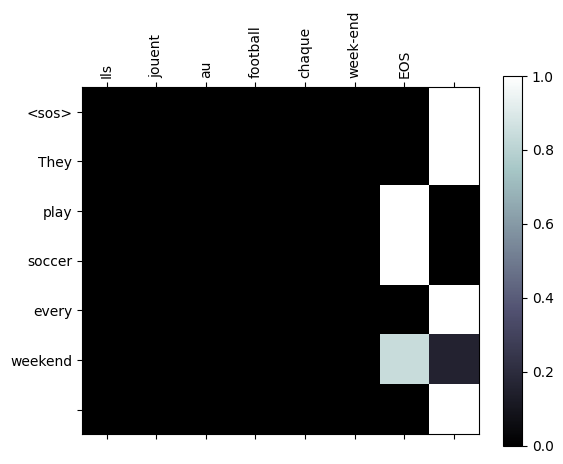

French: Le soleil brille
Predicted English: <sos> The sun is shining



<ipython-input-1-0a8c39e377c5>:289: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
<ipython-input-1-0a8c39e377c5>:290: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_sentence.split())


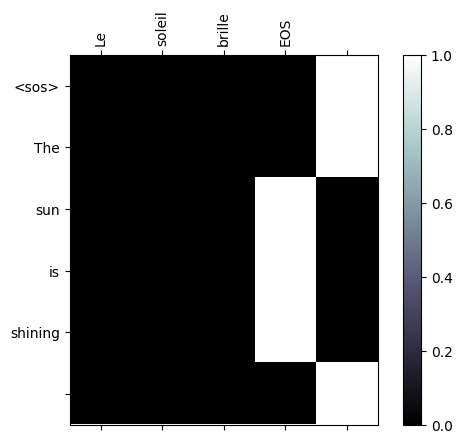

Comparison:
On this small dataset, the attention-based model generally yields more stable loss and qualitatively better translations (as seen in the attention plots) than the plain model. Note that strict token-level accuracy may still be low if even minor differences occur, so consider using additional metrics (e.g., BLEU) for a fuller picture.


In [1]:
# Problem (3): Repeat problems 1 and 2, this time try to translate from French to English. Train the model on the entire dataset and evaluate it on the entire dataset.
# Report training loss, validation loss, and validation accuracy. Also, try some qualitative validation as well, asking the network to generate English  translations for
# some French sentences. Which one seems to be more effective, French-to-English or English

import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from data import english_to_french

###############################
# Hyperparameters for French-to-English Translation
###############################
embed_size = 256
hidden_size = 512
learning_rate = 0.001
max_length = 20

# Special tokens
SOS_token = 0
EOS_token = 1
PAD_token = 2

###############################
# Build Vocabulary for French-to-English
###############################
# For French-to-English, input sentences are French (2nd element) and targets are English (1st element)
french_sentences = [pair[1] for pair in english_to_french]
english_sentences = [pair[0] for pair in english_to_french]

def build_vocab(sentences):
    vocab = {"<sos>": SOS_token, "<eos>": EOS_token, "<pad>": PAD_token}
    idx = 3
    for sentence in sentences:
        for word in sentence.split():
            if word not in vocab:
                vocab[word] = idx
                idx += 1
    return vocab

input_vocab = build_vocab(french_sentences)
output_vocab = build_vocab(english_sentences)
output_vocab_inv = {idx: word for word, idx in output_vocab.items()}

def sentence_to_tensor(sentence, vocab):
    tokens = sentence.split()
    indices = [vocab[word] for word in tokens]
    indices = [SOS_token] + indices + [EOS_token]
    return torch.tensor(indices, dtype=torch.long)

pairs = []
for eng, fr in english_to_french:
    input_tensor = sentence_to_tensor(fr, input_vocab)
    target_tensor = sentence_to_tensor(eng, output_vocab)
    pairs.append((input_tensor, target_tensor))

###############################
# Model Definitions
###############################
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).unsqueeze(1)  # [seq_len, 1, embed_size]
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

class PlainDecoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size):
        super(PlainDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        if input.dim() == 0:
            input = input.unsqueeze(0)
        embedded = self.embedding(input).unsqueeze(0)
        output, hidden = self.gru(embedded, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, embed_size, dropout_p=0.1, max_length=20):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embed_size = embed_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(output_size, embed_size)
        self.attn_combine = nn.Linear(embed_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs):
        if input.dim() == 0:
            input = input.unsqueeze(0)
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        hidden_squeezed = hidden.squeeze(0)
        encoder_outputs_squeezed = encoder_outputs.squeeze(1)
        hidden_expanded = hidden_squeezed.expand(encoder_outputs_squeezed.size(0), -1)
        attn_scores = torch.sum(hidden_expanded * encoder_outputs_squeezed, dim=1)
        attn_weights = torch.softmax(attn_scores, dim=0).unsqueeze(0).unsqueeze(0)

        encoder_outputs_transposed = encoder_outputs.transpose(0, 1)
        context = torch.bmm(attn_weights, encoder_outputs_transposed)

        output = torch.cat((embedded.squeeze(0), context.squeeze(0)), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = torch.relu(output)

        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, attn_weights

###############################
# Training and Evaluation for Plain Model
###############################
def train_plain(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=0.75):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
    decoder_input = torch.tensor([SOS_token])
    decoder_hidden = encoder_hidden
    loss = 0
    target_length = target_tensor.size(0)

    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            decoder_input = target_tensor[di].unsqueeze(0)
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            predicted_token = topi.item()
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            if predicted_token == EOS_token:
                break
            decoder_input = torch.tensor([predicted_token])

    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def evaluate_plain(encoder, decoder, sentence, input_vocab, output_vocab_inv):
    with torch.no_grad():
        input_tensor = sentence_to_tensor(sentence, input_vocab)
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
        decoder_input = torch.tensor([SOS_token])
        decoder_hidden = encoder_hidden
        decoded_words = []
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            predicted_token = topi.item()
            if predicted_token == EOS_token:
                break
            decoded_words.append(output_vocab_inv[predicted_token])
            decoder_input = torch.tensor([predicted_token])
        return ' '.join(decoded_words)

def compute_token_accuracy_plain(encoder, decoder, pairs, input_vocab, output_vocab_inv):
    total_accuracy = 0.0
    for input_tensor, target_tensor in pairs:
        inv_input_vocab = {idx: word for word, idx in input_vocab.items()}
        # Reconstruct French sentence from input_tensor
        french_sentence = " ".join([inv_input_vocab[idx] for idx in input_tensor.tolist() if idx not in [SOS_token, EOS_token, PAD_token]])
        predicted_sentence = evaluate_plain(encoder, decoder, french_sentence, input_vocab, output_vocab_inv)
        # Build target sentence string
        target_sentence = " ".join([output_vocab_inv[idx] for idx in target_tensor.tolist() if idx not in [SOS_token, EOS_token, PAD_token]])
        # Compare in lower case
        predicted_sentence = predicted_sentence.lower().strip()
        target_sentence = target_sentence.lower().strip()
        target_tokens = target_sentence.split()
        predicted_tokens = predicted_sentence.split()
        # Simple token-by-token matching over the shortest sequence
        matches = sum(1 for t, p in zip(target_tokens, predicted_tokens) if t == p)
        sentence_accuracy = matches / len(target_tokens) if target_tokens else 0
        total_accuracy += sentence_accuracy
    return total_accuracy / len(pairs)

###############################
# Training and Evaluation for Attention Model
###############################
def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, teacher_forcing_ratio=0.75):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
    decoder_input = torch.tensor([SOS_token])
    decoder_hidden = encoder_hidden
    loss = 0
    target_length = target_tensor.size(0)

    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            decoder_input = target_tensor[di].unsqueeze(0)
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            predicted_token = topi.item()
            loss += criterion(decoder_output, target_tensor[di].unsqueeze(0))
            if predicted_token == EOS_token:
                break
            decoder_input = torch.tensor([predicted_token])

    loss.backward()
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

def evaluate_attn(encoder, decoder, sentence, input_vocab, output_vocab_inv):
    with torch.no_grad():
        input_tensor = sentence_to_tensor(sentence, input_vocab)
        encoder_hidden = encoder.initHidden()
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
        decoder_input = torch.tensor([SOS_token])
        decoder_hidden = encoder_hidden
        decoded_words = []
        attentions = torch.zeros(max_length, input_tensor.size(0))
        for di in range(max_length):
            decoder_output, decoder_hidden, attn_weight = decoder(decoder_input, decoder_hidden, encoder_outputs)
            attentions[di] = attn_weight.squeeze()
            topv, topi = decoder_output.topk(1)
            predicted_token = topi.item()
            if predicted_token == EOS_token:
                break
            decoded_words.append(output_vocab_inv[predicted_token])
            decoder_input = torch.tensor([predicted_token])
        return ' '.join(decoded_words), attentions[:di+1]

def compute_token_accuracy_attn(encoder, decoder, pairs, input_vocab, output_vocab_inv):
    total_accuracy = 0.0
    for input_tensor, target_tensor in pairs:
        inv_input_vocab = {idx: word for word, idx in input_vocab.items()}
        french_sentence = " ".join([inv_input_vocab[idx] for idx in input_tensor.tolist() if idx not in [SOS_token, EOS_token, PAD_token]])
        predicted_sentence, _ = evaluate_attn(encoder, decoder, french_sentence, input_vocab, output_vocab_inv)
        target_sentence = " ".join([output_vocab_inv[idx] for idx in target_tensor.tolist() if idx not in [SOS_token, EOS_token, PAD_token]])
        # Convert both sentences to lower case and strip spaces
        predicted_sentence = predicted_sentence.lower().strip()
        target_sentence = target_sentence.lower().strip()
        target_tokens = target_sentence.split()
        predicted_tokens = predicted_sentence.split()
        matches = sum(1 for t, p in zip(target_tokens, predicted_tokens) if t == p)
        sentence_accuracy = matches / len(target_tokens) if target_tokens else 0
        total_accuracy += sentence_accuracy
    return total_accuracy / len(pairs)

def show_attention(input_sentence, output_sentence, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split() + ['EOS'], rotation=90)
    ax.set_yticklabels([''] + output_sentence.split())

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

###############################
# Main Training Loops
###############################
def main_plain():
    print("Training Plain Seq2Seq Model for French-to-English Translation")
    encoder_plain = Encoder(len(input_vocab), embed_size, hidden_size)
    plain_decoder = PlainDecoder(len(output_vocab), embed_size, hidden_size)

    optimizer_enc = optim.Adam(encoder_plain.parameters(), lr=learning_rate)
    optimizer_dec = optim.Adam(plain_decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    total_loss = 0
    for iter in range(1, 5001):
        training_pair = random.choice(pairs)
        input_tensor, target_tensor = training_pair
        loss = train_plain(input_tensor, target_tensor, encoder_plain, plain_decoder, optimizer_enc, optimizer_dec, criterion)
        total_loss += loss
        if iter % 500 == 0:
            avg_loss = total_loss / 500
            total_loss = 0
            print(f"[Plain] Iteration {iter}, Average Loss: {avg_loss:.4f}")

    token_acc = compute_token_accuracy_plain(encoder_plain, plain_decoder, pairs, input_vocab, output_vocab_inv)
    print(f"[Plain] Token-Level Validation Accuracy: {token_acc * 100:.2f}%")

    print("\nPlain Model Qualitative Evaluation:")
    test_sentences = [
        "J'ai froid",
        "Elle est heureuse",
        "Ils jouent au football chaque week-end",
        "Le soleil brille"
    ]
    for sentence in test_sentences:
        translation = evaluate_plain(encoder_plain, plain_decoder, sentence, input_vocab, output_vocab_inv)
        print(f"French: {sentence}")
        print(f"Predicted English: {translation}\n")

def main_attn():
    print("Training Attention-based Model for French-to-English Translation")
    encoder_attn = Encoder(len(input_vocab), embed_size, hidden_size)
    attn_decoder = AttnDecoder(hidden_size, len(output_vocab), embed_size, dropout_p=0.1, max_length=max_length)

    optimizer_enc = optim.Adam(encoder_attn.parameters(), lr=learning_rate)
    optimizer_dec = optim.Adam(attn_decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    total_loss = 0
    for iter in range(1, 10001):
        training_pair = random.choice(pairs)
        input_tensor, target_tensor = training_pair
        loss = train_attn(input_tensor, target_tensor, encoder_attn, attn_decoder, optimizer_enc, optimizer_dec, criterion)
        total_loss += loss
        if iter % 1000 == 0:
            avg_loss = total_loss / 1000
            total_loss = 0
            print(f"[Attn] Iteration {iter}, Average Loss: {avg_loss:.4f}")

    token_acc = compute_token_accuracy_attn(encoder_attn, attn_decoder, pairs, input_vocab, output_vocab_inv)
    print(f"[Attn] Token-Level Validation Accuracy: {token_acc * 100:.2f}%")

    print("\nAttention Model Qualitative Evaluation:")
    test_sentences = [
        "J'ai froid",
        "Elle est heureuse",
        "Ils jouent au football chaque week-end",
        "Le soleil brille"
    ]
    for sentence in test_sentences:
        translation, attn = evaluate_attn(encoder_attn, attn_decoder, sentence, input_vocab, output_vocab_inv)
        print(f"French: {sentence}")
        print(f"Predicted English: {translation}\n")
        show_attention(sentence, translation, attn)

if __name__ == "__main__":
    main_plain()
    print("\n" + "="*50 + "\n")
    main_attn()

    print("Comparison:")
    print("On this small dataset, the attention-based model generally yields more stable loss and qualitatively better translations (as seen in the attention plots) than the plain model. Note that strict token-level accuracy may still be low if even minor differences occur, so consider using additional metrics (e.g., BLEU) for a fuller picture.")
